In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lib import pseudo 
from lib import eval
from lib import utils
from scipy.optimize import minimize
import warnings
from warnings import warn
warnings.filterwarnings('error', category=UnicodeWarning)
import time 
import sys
import h5py
from itertools import combinations

%matplotlib inline

# Simple EA using lib.eval

In [45]:
L = 1; M = 4; N = 11
eps = 0.1; beta = 0.1
alpha = beta
_kxFun = utils._kxFun
_kzFun = utils._kzFun
norm = lambda arr: pseudo.chebnorm(arr, N)

kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)
y, DM = pseudo.chebdif(N, 2)
D1 = DM[:,:,0]; D2 = DM[:,:,1]
U = 1.-y**2; Uy = -2.*y


flowDict = {"Re":10., "U":U, "Uy":Uy, "y":y, "D1":D1, "D2":D2,\
           "eps":eps, "beta":beta}

def costFun(state,scale=1.e+4):
    state = scale * state # To improve conditioning
    derivs = utils.calcDerivatives(state, kxArr, kzArr, 
                        flowDict=flowDict, wavy=True)
    linTerm = eval.getLinTerm(state, kxArr, kzArr, 
                flowDict, derivs=derivs)
    linCost = norm(linTerm)
    return linCost

def getMutation(stdArr, l=None, m=None,c=None):
    mutation = np.zeros((2*L, M+1, 4, N), dtype=np.complex)
    if (m is None) and (l is None) and (c is None):
        for lx in range(kxArr.size):
            for lz in range(kzArr.size):
                for lc in range(4):
                    mutation[lx,lz,lc] = ( 
                        np.random.normal(0., stdArr[lx,lz,lc], (1,y.size) ) + 
                        1.j* np.random.normal(0., stdArr[lx,lz,lc], (1,y.size) )    )
    else :
        mutation[l,m,c] = ( 
                np.random.normal(0., stdArr[l,m,c], (1,y.size) ) + 
                1.j* np.random.normal(0., stdArr[l,m,c], (1,y.size) )    )
    
    mutation[0,0] = np.real(mutation[0,0])
    
    return mutation


In [46]:
scale = 1.
residFun = lambda arr: costFun(arr, scale=scale)
state = 1.e-10*np.ones((kxArr.size, kzArr.size, 4, N), dtype=np.complex)
parent = state
stdArr = np.zeros((2*L, M+1,4)) # All modes except u_00 should be zero
stdArr[0,0,0] = 1.e-4
costFun(state)

0.0001235032016171167

0 0.00012382779756989947 0.0 9.878765474230741e-05
1 0.00012382779756989947 0.0 9.759000729485331e-05
2 0.00012382779756989947 0.0 9.64068794694323e-05
3 0.00012382779756989947 0.0 9.523809523809521e-05
4 0.00012382779756989947 0.0 9.408348070695941e-05
5 0.00012382779756989947 0.0 9.294286409033647e-05
6 0.00012382779756989947 0.0 9.18160756851736e-05
7 0.00012382779756989947 0.0 9.070294784580495e-05
8 0.00012382779756989947 0.0 8.960331495900895e-05
9 0.00012382779756989947 0.0 8.851701341936804e-05
10 0.00012382779756989947 0.0 8.744388160492721e-05
20 0.00012382779756989947 0.0 7.740271241464972e-05
30 0.00012382779756989947 0.0 6.851456933503036e-05
40 0.00012382779756989947 0.0 6.064705053251105e-05
50 0.00012382779756989947 0.0 5.3682957858313735e-05
60 0.00012382779756989947 0.0 4.751855101135728e-05
70 0.00012382779756989947 0.0 4.206200217541238e-05
80 0.00012382779756989947 0.0 3.723202811006466e-05
90 0.00012382779756989947 0.0 3.295667931848882e-05
100 0.00012382779756989

C:\Users\Sabarish\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


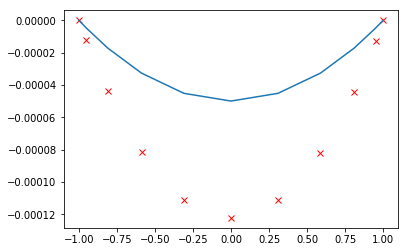

In [47]:
iter0 = 0 #======================= Important
iterMax = 15001
iterSwitch0  = 50
iterSwitchInt= 100
alpha = 1.05
iterPrint = 10
tol = 1.e-14


np.set_printoptions(precision=4)
for iternum in range(iter0,iterMax):
    if (iternum<50) or (iternum%20):
        for l in range(2*L):
            for m in range(M+1):
                for c in range(4):
                    offspring = parent + getMutation(stdArr, m=m, l=l, c=c)
                    costOff = residFun(offspring)
                    costPar = residFun(parent)

                    if costOff <= costPar:
                        parent = np.copy(offspring)
                        stdArr[l,m,c] = stdArr[l,m,c]*alpha
                    else :
                        parent = parent
                        stdArr[l,m,c] = stdArr[l,m,c] * alpha**(-1./4.)
    else :
        offspring = parent + getMutation(stdArr)
        costOff = residFun(offspring)
        costPar = residFun(parent)

        if costOff <= costPar:
            parent = np.copy(offspring)
            stdArr = stdArr*alpha
        else :
            parent = parent
            stdArr = stdArr * alpha**(-1./4.)
        
    if min(costOff,costPar) < tol:
        print(); print("Exiting...")
        print(iternum, min(costOff,costPar))
        break

    if iternum <= 10:
        print(iternum, min(costOff, costPar), np.amin(stdArr.flat),np.amax(stdArr.flat) )
    
    if (10 < iternum <= 100):
        if iternum%10 == 0:
            print(iternum, min(costOff, costPar),np.amin(stdArr.flat),np.amax(stdArr.flat) )
    
    if (100 < iternum <= 1000):
        if iternum%100 == 0:
            print(iternum, min(costOff, costPar),np.amin(stdArr.flat),np.amax(stdArr.flat) )
    
    if (1000 < iternum <= 10000):
        if iternum%500 == 0:
            print(iternum, min(costOff, costPar),np.amin(stdArr.flat),np.amax(stdArr.flat) )
            
plt.plot(y, (1.-y**2)*parent[0,0,0], 'rx')
plt.plot(y, (1.-y**2)*(-(eps*beta)**2)/2.)
plt.show()